In [14]:
import os
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import sys
from scipy.optimize import curve_fit
from astropy.convolution import convolve, Gaussian1DKernel
from mpl_toolkits.axes_grid1 import ImageGrid
import math

#Astropy modules to deal with coordinates
from astropy.wcs import WCS
from astropy.wcs import Wcsprm
from astropy.io import fits
from astropy.wcs import utils

#BTS code developed by Seamus to get nice moment maps using cube masking
#instead of sigma clippping

module_path = os.path.abspath(os.path.join('/Users/christianflores/Documents/Work/BTS-master/')) # or the path to your source code
sys.path.insert(0, module_path)
import BTS
# sys.path.insert(0, module_path)


## Helper functions
These are general purpose functions

In [17]:
def closest_idx(lst, val):
     lst = np.asarray(lst)
     idx = (np.abs(lst - val)).argmin()
     return idx

# The ALMA TP Data 
Thi class handles the basic properties of the fits files produced by ALMA.
It will fits open the fits file, read the header and the data.
It will save some important information such as the velocity of the cube,
and read the astronomical coordinates of the system.

"More escription needed"


In [18]:
class ALMATPData:
    def __init__(self, path, filename):
        self.image = 1

#         try:
        data_cube = fits.open(os.path.join(path, filename))
#         except:
#              data_cube = fits.open(os.path.join(path, filename + '.fits'))


        self.filename = filename
        self.header = data_cube[0].header
        self.ppv_data = data_cube[0].data
    
        # If the data has a 4 dimension, turn it into 3D
        if(np.shape(data_cube[0].data)[0] == 1):
            self.ppv_data = data_cube[0].data[0,:,:,:]            

            
        self.nx = self.header['NAXIS1']
        self.ny = self.header['NAXIS2']
            
        try:
            self.nz = self.header['NAXIS3']
            self.vel = self.get_vel(self.header)
            dv = self.vel[1] - self.vel[0]
            if(dv<0):
                dv = dv*-1
        
        except: 
            print('This is a 2D image')
            
        self.wcs = WCS(self.header)
        

    def get_vel(self,head):
        
        
        ### If the header data is stored as frequency then convert to velocity [in km/s]
        if "f" in head['CTYPE3'].lower():

            df = head['CDELT3']
            nf = head['CRPIX3'] 
            fr = head['CRVAL3']

            ff = np.zeros(head["NAXIS3"])
            for ii in range(0,len(ff)):
                ff[ii] = fr + (ii-nf+1)*df

            rest = self.accurate_reference_frequency(self.filename)#head["RESTFRQ"]

            vel = (rest-ff) / rest * 299792.458 
            return vel

        elif "v" in head['CTYPE3'].lower():

            refnv = head["CRPIX3"]
            refv = head["CRVAL3"]
            dv = head["CDELT3"]
            ### Construct the velocity axis 

            vel = np.zeros(head["NAXIS3"])
            for ii in range(0,len(vel)):
                vel[ii] = refv + (ii-refnv+1)*dv

            return vel

        else:

            print("The CTYPE3 variable in the fitsfile header does not start with F for frequency or V for velocity")
            return
        
    def accurate_reference_frequency(self, filename):
        if "spw17" in filename:
            freq_rest =2.16278749E+11#c-C3H2
            freq_rest =2.16112628E+11#
            mole_name="DCO+"

        if "spw19" in filename:
            freq_rest =2.19949433E+11
            mole_name="SO"

        if "spw21" in filename:
            freq_rest = 2.19560353E+11
            mole_name="C18O"

        if "spw23" in filename:
            freq_rest = 2.30538000E+11
            mole_name="12CO"

        if "spw25" in filename:
            freq_rest = 2.31220768E+11
            mole_name="13CS"

        if "spw27" in filename:
            freq_rest = 2.31321635E+11
            mole_name="N2D+"
        return float(freq_rest)#,mole_name
        

In [19]:
def plot_moment_maps(path,filename,moment):
    
    data_cube = ALMATPData(path,filename)
    image = data_cube.ppv_data
    
    fig = plt.subplot(projection=data_cube.wcs)
    figure = fig.imshow(image,cmap="viridis", origin='lower')
    
    peak=np.nanmax(image)
    levels = np.array([0.3, 0.4, 0.5, 0.6,0.7,0.8,0.85, 0.9,0.95])
    levels=levels* peak
    
    contour = plt.contour(image, levels=levels,colors="black")

    if moment == 0: 
        cbar = plt.colorbar(figure, label='Integrated Intensity (Jy/beam * km/s)')
        plt.clabel(contour, inline=True, fontsize=8)
    elif moment == 1: 
        cbar = plt.colorbar(figure, label='Velocity (km/s)')
        plt.clabel(contour, inline=True, fontsize=8)
    elif moment == 2: 
        cbar = plt.colorbar(figure, label='Velocity width (km/s)')
        plt.clabel(contour, inline=True, fontsize=8)
        
    fig.tick_params(labelsize=12)
    plt.show()            


This is a 2D image


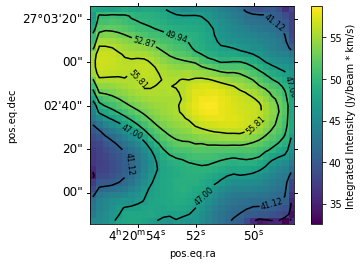

In [20]:
cwd = os.getcwd()
plot_moment_maps(path=cwd + '/Cube_moment_fits/', filename='C18O_cube_M490_mom0.fits',moment=0)

In [21]:
def get_files_in_directory(directory_path):
    '''
    This function returns a list of the
    files and directories in directory_path
    '''
    try:
        #get a list of files and directory 
        file_list = os.listdir(directory_path)

        # Get only file names in directory 
        file_list = [file for file in file_list if os.path.isfile(os.path.join(directory_path, file))]

        return file_list
    except OSError as e:
        print(f"Error: {e}")
        return []

## This function makes an average spectrum over the whole FOV
I think it would be better to change it in such a way that it takes into account
a the mask created with the BTS output masking file.
Add to future work.

In [22]:
def make_average_spectrum_data(path,filename):
    """
    Average spectrum of the whole cube.
    """
    count=0
    data_cube = ALMATPData(path,filename)
    velocity = data_cube.vel
    image = data_cube.ppv_data
    average_spectrum = np.nanmedian(image,axis=(1,2))
    
    return average_spectrum,velocity

In [23]:
def plot_average_spectrum(path,filename):    
    """
    This one plots the average spectrum
    """
    spectrum, velocity = make_average_spectrum_data(path,filename)
    plt.figure()
#     plt.title("Averaged Spectrum ("+mole_name+") @"+dir_each)
    plt.xlabel("velocity [km/s]")
    plt.ylabel("Intensity")
    # Set the value for horizontal line 
    y_horizontal_line = 0
    plt.axhline(y_horizontal_line, color='red', linestyle='-')
#     plt.axvline(Vsys, color='red', linestyle='--')
    plt.plot(velocity,spectrum,"-",color="black",lw=1)
    plt.tick_params(axis='both', direction='in')
    plt.xlim(-20,20)
    plt.show()

In [119]:
def calculate_peak_SNR(path,filename,velo_limits=[-20,20]):
    '''
    Calculates the peak SNR over the whole cube.
    It is possible to set velocity limits for the calculation 
    of noise in line-free regions.
    The noise is calculated as the std of images in line-free channels,
    averaged over many channels.
    '''
    
    data_cube = ALMATPData(path,filename)
    image = data_cube.ppv_data
    velocity = data_cube.vel
    peak_signal_in_cube = np.nanmax(image)
    
    val_down, val_up = velo_limits[0],velo_limits[1]
    lower_idx,upper_idx = closest_idx(velocity, val_down), closest_idx(velocity, val_up)
    
    array_of_noise_lower = np.nanstd(image[:lower_idx,:,:],axis=0)
    array_of_noise_upper = np.nanstd(image[upper_idx:,:,:],axis=0)

    average_noise_images = (np.nanmean(array_of_noise_lower)+np.nanmean(array_of_noise_upper))/2.
    
    return round(peak_signal_in_cube/average_noise_images,1)
    



    

In [120]:
calculate_peak_SNR(path='TP_FITS/M465',
                           filename='member.uid___A001_X15aa_X29e.M465_sci.spw21.cube.I.sd.fits')

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


25.9

In [121]:
def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

## Gaussian parameters from fit to spectra
This function returns the centroid, amplitude, and width of
N gaussians fit to the observed spectra

In [122]:
def gaussian_parameters_of_spectra(velocity, spectrum, guess=[],plot=False):
    '''
    guess is a 3-tuple of centroid, amplitude, and width
    Need to improve for non-overalaping centers.
    Basically, each component is restricted in a portion
    of the larger velocity array
    '''
    if guess==[]:
        guess = [7, 5, 2]
    
    rms = np.nanstd(spectrum[10:40])
#     gaussian_kernel = Gaussian1DKernel(3)
#     smoothed_spectrum = convolve(spectrum,gaussian_kernel)
    
    n_bound = int(len(guess)/3.)
    bounds = ((2,rms*8,1e-3)*n_bound,(10,100,10)*n_bound)

    popt, pcov = curve_fit(func, velocity, spectrum, p0=guess, bounds=bounds)
    average_centroid = np.nanmedian(popt[::3])
    fit = func(velocity, *popt)

    if plot:
#         plt.plot(velocity,smoothed_spectrum)
        plt.plot(velocity,spectrum)
        plt.plot(velocity, fit , 'r-')
        plt.xlim(average_centroid-5,average_centroid+5)
#         plt.xlim(0,10)
        plt.show()

    return popt


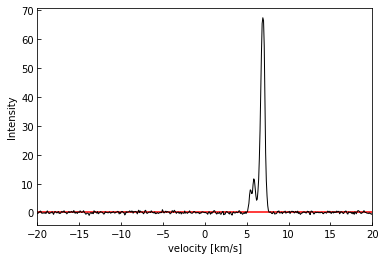

In [123]:
plot_average_spectrum(path='TP_FITS/M490',
                           filename='member.uid___A001_X15aa_X2a6.M490_sci.spw21.cube.I.sd.fits')

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


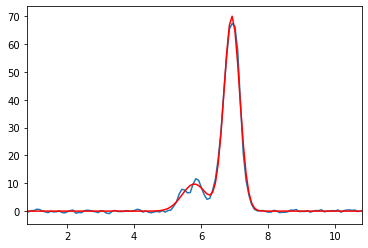

array([3.42992470e+00, 1.86628786e+00, 1.07650140e-03, 5.79976948e+00,
       9.74048466e+00, 5.16009850e-01, 6.91894056e+00, 7.00253901e+01,
       3.31839653e-01])

In [124]:
spectrum, velocity = make_average_spectrum_data(path='TP_FITS/M490',
                           filename='member.uid___A001_X15aa_X2a6.M490_sci.spw21.cube.I.sd.fits')

guess = [4,10,1,5,10,1,8,10,3]
gaussian_parameters_of_spectra(velocity, spectrum, guess,plot=True)

In [132]:
def find_all_spectra_for_a_molecule(folders_path):
    '''
    Find the path to all the spectra of a given molecule
    '''
    array_of_paths=[]
    molecule = '.spw23.'
    folder_list = next(os.walk(folders_path))[1]
    for each_folder in folder_list:
        filenames = get_files_in_directory(os.path.join(folders_path,each_folder))
        for names in filenames:
            if molecule in names:
                array_of_paths.append(os.path.join(each_folder,names))
    return array_of_paths

In [135]:
def plot_grid_of_spectra(folders_path):
    
    array_of_paths = find_all_spectra_for_a_molecule(folders_path)
    
    number_of_sources = len(array_of_paths)
    grid_size = int(math.ceil(number_of_sources**0.5))
    fig = plt.figure(figsize=(15., 15.))

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(grid_size, grid_size),  # creates 2x2 grid of Axes
                 axes_pad=0.3, aspect=False  # pad between Axes in inch.
                 )
        
    for ax, sources in zip(grid, array_of_paths):
#     for sources in array_of_paths:
        spectrum, velocity = make_average_spectrum_data(path='TP_FITS',
                               filename=sources)
    
        SNR = calculate_peak_SNR(path='TP_FITS', filename=sources)
        ax.plot(velocity,spectrum)
        ax.set_xlim(-6,18)
        ax.set_title(sources.split('/')[0])
        
        ax.text(x=0.05, y=0.9, s='SNR = ' + str(int(SNR)), ha='left', va='top',
                 transform=ax.transAxes, size=12, color='purple')
        
#     for ax, im in zip(grid, [im1, im2, im3, im4]):
#         Iterating over the grid returns the Axes.
#         ax.imshow(im)

    plt.show()

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/christianflores/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/christianflores/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/christianflores/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
Set OBSGEO-B to   -23.022886

/Users/christianflores/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/christianflores/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/christianflores/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/christianflores/opt/

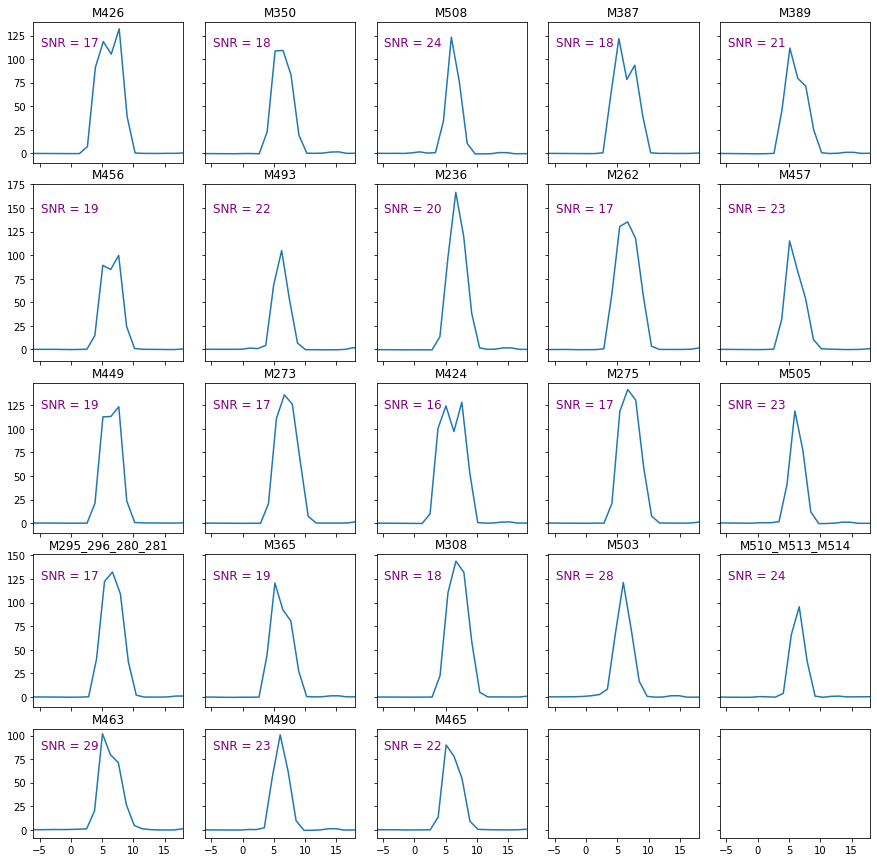

In [136]:
plot_grid_of_spectra('TP_FITS')


## This code below defines the rest frequency of some molecules
I am not sure if this is the best way of saving this information. Possibly, a text file would be preferred.
Also, for some molecules, the rest frequency defined here is different from the one in the header.
In principle, our code should compare the list with the header and take whatever we think is more accurate.

# This is the code that actually computes the moment 0, 1, and 2 maps.
It uses BTS, and it reads a text file. The paramters of the text file must be defined per each sources.

In [53]:
# #### Example to show how to make moment maps from a fits cube and then fit the entire cube
# # Read in the relevant parameter file

param = BTS.read_parameters("TP_FITS/M490/Fit_cube.param")

print(os.getcwd())

# # Run the function to make the moments using the moment-masking technique
# BTS.make_moments(param)

# # Using the generated mask, fit the entire datacube
# BTS.fit_a_fits(param)



 
 
 
############################################
################ Parameters ################
############################################

############# Important three ##############
Delta AIC limit                 =  10.0
Smoothing length                =  3.0
Signal to noise ratio           =  10.0
 
############# Input/Output names ###########
Input Fits file name            =  TP_FITS/M490/C18O.fits
Output file base name           =  C18O_cube_M490
 
######## Spectral fitting parameters #######
Maximum number of peaks allowed =  4
Maximum number of iterations    =  5
Minimum number of channels      =  5
Minimum component width         =  0.5
Maximum component width         =  50.0
Mask padding value              =  3
 
######## Non-test noise parameters #########
Variable noise                  =  1
 
######### Moment-masking parameters ########
Noise velocity channel width    =  100
Upper sigma level for masking   =  10.0
Lower sigma level for masking   =  5.0
Top-hat filter s

In [31]:
# select targets  
dir="./TP_FITS/" ### Change name of this variable because it is a built-in function name

# dir_eachs=["M236", "M350", "M449", "M493",
#            "M262", "M365", "M456", "M503",
#            "M273", "M387", "M457", "M505",
#            "M275", "M389", "M463", "M508",
#            "M295_296_280_281", "M424", "M465", "M510_M513_M514",
#            "M308", "M426", "M490"]
dir_eachs=["M490"]
#dir_eachs=["M510_M513_M514"]

target=[]
mole=[]
detect_status=[]

for j in range(len(dir_eachs)):
    dir_each=dir_eachs[j]
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("||||||||||||||||||||||||||||||||||||||||     "+dir_each+"   ||||||||||||||||||||||||||||||||||||||||||||||")
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

    directory_path = dir+dir_each  # Change the path following your environment  
    files_in_directory = get_files_in_directory(directory_path)
    file_name_common=files_in_directory[0][:-21]

    spws=["spw21"]#,"spw19","spw21","spw23","spw25","spw27"]

    Vsys=7.0
    range_value=5.0
    thresh=7.5#sigma

    mom_range_begin=[]
    mom_range_end=[]
    
    for i in range(len(spws)):
        spw=spws[i]
        file_end,freq_rest,mole_name=frest_mole(spw)
        fits_file_path=dir+dir_each+"/"+file_name_common+file_end
        image_data,velocity_axis_kms,naxis1_value,naxis2_value,naxis3_value,bmag_value,header= read_fits(fits_file_path, freq_rest) 

        rms_start_ch=int(naxis3_value*2./10)
        rms_end_ch=int(naxis3_value*4./10)
        selected_channels = image_data[rms_start_ch:rms_end_ch]
        rms=np.nanstd(selected_channels)
        
        velo_range_count=0
        SN_value=0.
        
        ### I think tis part just gets the maximum SNR in the region where the line is suppose to be.
        for k in range(len(velocity_axis_kms)):
            max_value_map=np.nanmax(image_data[k])
            if (velocity_axis_kms[k] >= Vsys- range_value ) and (velocity_axis_kms[k] <= Vsys+ range_value ):
                SN_value_tmp=max_value_map/rms
                if SN_value_tmp >= SN_value:
                    SN_value=round(SN_value_tmp,1)
                if (max_value_map >= rms*thresh):
                    velo_range_count=velo_range_count+1
                
        if velo_range_count == 0:
            target.append(dir_each)
            mole.append(mole_name)
            #detect_status.append("X")
            input="X ("+str(SN_value)+")"
            detect_status.append(input)
            
        if velo_range_count != 0:
            target.append(dir_each)
            mole.append(mole_name)
            #detect_status.append("O")
            input="O ("+str(SN_value)+")"
            detect_status.append(input)
            
        default_size=7
        default_size2=7
        
        ### Here is just setting the layout for a figure, like chanel maps
        if velo_range_count == 1:
            plot_x,plot_y=1,1
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size
        if velo_range_count == 2:
            plot_x,plot_y=1,2            
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size
        if velo_range_count == 3:
            plot_x,plot_y=1,3            
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size
        if velo_range_count == 4:
            plot_x,plot_y=1,4            
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size
        if velo_range_count == 5:
            plot_x,plot_y=1,5            
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size
            
        if (velo_range_count >= 6) and (velo_range_count <= 10):
            plot_x,plot_y=2,5           
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2    
        if (velo_range_count >= 11) and (velo_range_count <= 15):
            plot_x,plot_y=3,5           
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2
        if (velo_range_count >= 16) and (velo_range_count <= 20):
            plot_x,plot_y=4,5           
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2
        if (velo_range_count >= 21) and (velo_range_count <= 25):
            plot_x,plot_y=5,5           
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2
        if (velo_range_count >= 26) and (velo_range_count <= 30):
            plot_x,plot_y=6,5           
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2       
        if (velo_range_count >= 31) and (velo_range_count <= 36):
            plot_x,plot_y=6,6           
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2
        if (velo_range_count >= 37) :
            plot_x,plot_y=7,7
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2
            
        if velo_range_count == 0:            
            mom_range_begin.append(-100)
            mom_range_end.append(100)
            
        ### Here is plotting the figures. This looks like a channel map.
        if velo_range_count >= 1:
            velo_range_count=0
            plt.figure(figsize=(figsize_x,figsize_y))
            plt.figure()
            plt.title(mole_name+"@"+dir_each)
            text=mole_name+"@"+dir_each
            print(text)
            mom_min_velo=100.
            mom_max_velo=-100.
            for k in range(len(velocity_axis_kms)):
                max_value_map=np.nanmax(image_data[k])
                if (velocity_axis_kms[k] >= Vsys- range_value ) and (velocity_axis_kms[k] <= Vsys+ range_value ):
                    if (max_value_map >= rms*thresh):
                        if velocity_axis_kms[k] <= mom_min_velo:
                            mom_min_velo=velocity_axis_kms[k]
                        if velocity_axis_kms[k] >= mom_max_velo:
                            mom_max_velo=velocity_axis_kms[k]                        
                        
                        velo_range_count=velo_range_count+1
                        num=velo_range_count
                        plt.subplot(plot_x,plot_y,num)
                        plt.xlim(0,naxis1_value)
                        plt.ylim(0,naxis2_value)
                        plt.imshow(image_data[k],cmap="rainbow",vmin=np.nanmin(image_data),vmax=np.nanmax(image_data))
                        relative_x=0.05
                        relative_y=0.9
                        velo_text=round(velocity_axis_kms[k],2)
                        plt.text(relative_x, relative_y, str(velo_text)+"km/s", transform=plt.gca().transAxes)
                        plt.axis('off')

            plt.tight_layout()  
            plt.show()
            
            ## The velocity of the moment maps are defined by hand in a function
            mom_min_velo_tmp,mom_max_velo_tmp=define_mom_velo(dir_each,spw,mom_min_velo,mom_max_velo)
            
            print("min,TTT",mom_min_velo_tmp, "km/s")
            print("max,TTT",mom_max_velo_tmp, "km/s")            
            mom_range_begin.append(mom_min_velo_tmp)
            mom_range_end.append(mom_max_velo_tmp)
            mom_min_velo=mom_min_velo_tmp
            mom_max_velo=mom_max_velo_tmp
            
            
            ## Here the moment maps are plotted

            if num >=3:
                # Set the velocity range 
                min_velocity = mom_min_velo-0.05  # Min velocity（km/s）
                max_velocity = mom_max_velo+0.05   # Max velocity （km/s）

                velocity_mask = (velocity_axis_kms >= min_velocity) & (velocity_axis_kms <= max_velocity)
                data_cube_cut = image_data[velocity_mask, :, :]
                
                moment_0_map = np.sum(data_cube_cut, axis=0)            
                
                #Set intensity threshold 
                intensity_threshold = rms*5.0#5sigma

                # Making mask to neglect the pixels below the intensity threshold  
                intensity_mask = data_cube_cut < intensity_threshold
                data_cube_cut[intensity_mask] = 0.0  # set 0 to the pixels below intensity threshold 

                # Make mom 1 maps 
                weighted_velocity = np.sum(data_cube_cut * velocity_axis_kms[velocity_mask, None, None], axis=0) / np.sum(data_cube_cut, axis=0)

                peak=np.nanmax(moment_0_map)
                levels = np.array([0.3, 0.4, 0.5, 0.6,0.7,0.8,0.85, 0.9,0.95])
                levels=levels* peak
                
                #Plot Mom 1 map
                plt.figure()
                plt.xlim(0,naxis1_value)
                plt.ylim(0,naxis2_value)
                plt.imshow(weighted_velocity, cmap='bwr',  vmin=min_velocity, vmax=max_velocity)
                plt.colorbar(label='Velocity (km/s)')
                contour=plt.contour(moment_0_map, levels=levels,colors="black",lw=0.5)
                plt.clabel(contour, inline=True, fontsize=8)

                plt.xlabel('X-axis (pixel)')
                plt.ylabel('Y-axis (pixel)')
                plt.title('Moment 1 Map')
                plt.axis('off')
                plt.show()            
                
                #Plot Mom 0 map
                plt.figure()
                plt.xlim(0,naxis1_value)
                plt.ylim(0,naxis2_value)
                plt.imshow(moment_0_map, cmap='rainbow')
                plt.colorbar(label='Flux')
                contour=plt.contour(moment_0_map, levels=levels,colors="black",lw=0.5)
                plt.clabel(contour, inline=True, fontsize=8)
                plt.xlabel('X-axis (pixel)')
                plt.ylabel('Y-axis (pixel)')
                plt.title('Moment 0 Map')
                plt.axis('off')
                plt.show()            
            print("==================================================")
            print("==================================================")
            print("==================================================")

    plt.figure(figsize=(12,6))
    
    ## Here the spectrum of the source is plotted
    for i in range(len(spws)):
        spw=spws[i]
        file_end,freq_rest,mole_name=frest_mole(spw)
        fits_file_path=dir+dir_each+"/"+file_name_common+file_end
        image_data,velocity_axis_kms,naxis1_value,naxis2_value,naxis3_value,bmag_value,header= read_fits(fits_file_path, freq_rest)
        average_spectrum=make_average_spectrum_data(image_data,naxis1_value,naxis2_value,naxis3_value)
        #make_average_spectrum(average_spectrum,velocity_axis_kms,mole_name,dir_each)
        
        num=int(i+1)
        plt.subplot(2,3,num)
        #plt.title("Averaged Spectrum ("+mole_name+") @"+dir_each)
        relative_x=0.05
        relative_y=0.9
        plt.text(relative_x, relative_y, mole_name+"@"+dir_each, transform=plt.gca().transAxes)

        plt.xlabel("velocity [km/s]")
        plt.ylabel("Intensity")
        plt.xlim(-5,15)
        # set the value for horizontal line
        y_horizontal_line = 0
        plt.axhline(y_horizontal_line, color='red', linestyle='-')

        plt.axvline(Vsys, color='red', linestyle='--')
        plt.plot(velocity_axis_kms,average_spectrum,"-",color="black",lw=1)
        plt.tick_params(axis='both', direction='in')
        if (mom_range_begin[i] != -100) :
            plt.plot([mom_range_begin[i],mom_range_end[i]],[0,0],"-",color="blue")
        
    plt.show()        
    
    
data = {
    'Target': target,
    'Molecule': mole,
    'Detect': detect_status
}

df = pd.DataFrame(data)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||     M490   ||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


NameError: name 'frest_mole' is not defined

In [36]:
pivot_table = pd.pivot(data=df, index='Target', columns='Molecule', values='Detect')
print("Results based on threshold:",thresh, "sigma")
pivot_table

Results based on threshold: 7.5 sigma


Molecule,C18O
Target,
M490,O (73.9)


In [30]:
pivot_table = pd.pivot(data=df, index='Molecule', columns='Target', values='Detect')
print("Results based on threshold:",thresh, "sigma")
pivot_table

Results based on threshold: 7.5 sigma


Target,M490
Molecule,
DCO+,O (13.8)


In [31]:
dir_each="M493"
spw="spw21"

directory_path = dir+dir_each  # 自分のディレクトリのパスに置き換えてください
files_in_directory = get_files_in_directory(directory_path)
file_name_common=files_in_directory[0][:-21]

file_end,freq_rest,mole_name=frest_mole(spw)
fits_file_path=dir+dir_each+"/"+file_name_common+file_end

In [32]:
print(fits_file_path)

./TP_FITS/M493/member.uid___A001_X15aa_X29e.M493_sci.spw21.cube.I.sd.fits


In [33]:
image_data,velocity_axis_kms,naxis1_value,naxis2_value,naxis3_value,bmag_value,header= read_fits(fits_file_path, freq_rest) 

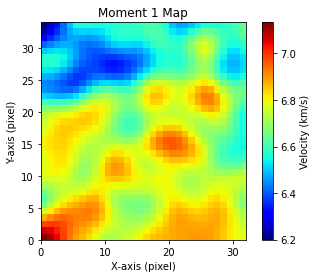

In [34]:
# 速度範囲の指定
min_velocity = 2  # 最小速度（km/s）
max_velocity = 12   # 最大速度（km/s）

velocity_mask = (velocity_axis_kms >= min_velocity) & (velocity_axis_kms <= max_velocity)
data_cube_cut = image_data[velocity_mask, :, :]
# モーメント1マップを計算する（重み付け平均速度を計算）
weighted_velocity = np.sum(data_cube_cut * velocity_axis_kms[velocity_mask, None, None], axis=0) / np.sum(data_cube_cut, axis=0)

# モーメント1マップをプロットする
plt.imshow(weighted_velocity, origin='lower', cmap='jet', extent=[0, header['NAXIS1'], 0, header['NAXIS2']])
plt.colorbar(label='Velocity (km/s)')
plt.xlabel('X-axis (pixel)')
plt.ylabel('Y-axis (pixel)')
plt.title('Moment 1 Map')
plt.show()